In [1]:
import torch                     # importing libraries
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
from sklearn.datasets import make_circles  # circle dataset loading

X, y = make_circles(2000, noise = 0.02, random_state = 40)
data = pd.DataFrame({"X0": X[:, 0], "X1": X[:, 1], "y": y})

<ipython-input-3-47cd404bcf61>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(x=X[:,0], y=X[:,1],c=y, cmap=plt.cm.get_cmap( 'RdYlBu_r',10))


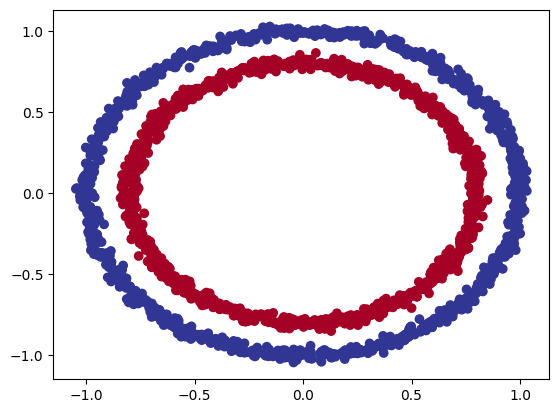

In [3]:
plt.scatter(x=X[:,0], y=X[:,1],c=y, cmap=plt.cm.get_cmap( 'RdYlBu_r',10))
plt.show()

In [4]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # splitting iin training and testt set

In [7]:
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=12),
    nn.ReLU(),  # Applies the rectified linear unit function element-wise
    nn.Linear(in_features=12, out_features=12),
    nn.ReLU(),
    nn.Linear(in_features=12, out_features=1)
)

In [16]:
loss_fn = nn.BCEWithLogitsLoss()  # loss function  tells how wrong our model gives prediction
optimizer = torch.optim.SGD(params = model.parameters(), lr=0.1) # the goal of optimizer is to optimizer our model parameters in such a way that loss_fn go down

In [17]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [18]:
torch.manual_seed(42)

for epoch in range(1000):

  model.train()
  y_logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                            y_pred=test_pred)
  if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.68753, Accuracy: 54.75% | Test Loss: 0.69023, Test Accuracy: 49.00%
Epoch: 100 | Loss: 0.68273, Accuracy: 57.06% | Test Loss: 0.68630, Test Accuracy: 52.25%
Epoch: 200 | Loss: 0.67600, Accuracy: 61.69% | Test Loss: 0.68003, Test Accuracy: 56.50%
Epoch: 300 | Loss: 0.66537, Accuracy: 67.19% | Test Loss: 0.66917, Test Accuracy: 64.75%
Epoch: 400 | Loss: 0.64750, Accuracy: 75.62% | Test Loss: 0.65002, Test Accuracy: 72.25%
Epoch: 500 | Loss: 0.61522, Accuracy: 85.75% | Test Loss: 0.61548, Test Accuracy: 80.50%
Epoch: 600 | Loss: 0.55994, Accuracy: 94.25% | Test Loss: 0.55762, Test Accuracy: 92.00%
Epoch: 700 | Loss: 0.46681, Accuracy: 98.69% | Test Loss: 0.46146, Test Accuracy: 98.00%
Epoch: 800 | Loss: 0.32504, Accuracy: 100.00% | Test Loss: 0.31927, Test Accuracy: 100.00%
Epoch: 900 | Loss: 0.19097, Accuracy: 100.00% | Test Loss: 0.18712, Test Accuracy: 100.00%


In [19]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

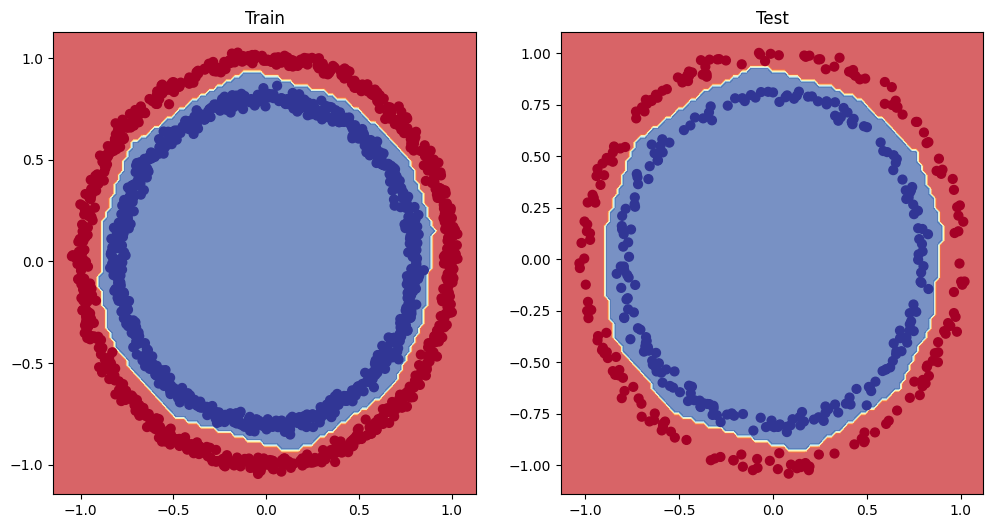

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

***After training it with different learning rate got 100 percent accuracy in 1000 epochs, in this case the best learning rate is 0.1 although in the previous notebook because of not any non linear activation function the neural network was not able to extract exact outcome and draw the straight line***